## Ground Truth Generation From Labeled Test Data

#### Imports

In [2]:
import numpy as np
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import os

#### Label Mapping

In [ ]:
label_dict = {}
label_list = yaml.load(open('custom_data.yaml'),Loader=yaml.FullLoader)['CLASSES']
label_list = label_list[1:]
for i,label in enumerate(label_list):
    label_dict[label] = i+1
print(label_list)
print(label_dict)
DATASET_PATH = 'compare_resnet50'
output_path = f'outputs/confusion_matrix/{DATASET_PATH}'
os.makedirs(output_path,exist_ok=True)

['button', 'input', 'checkbox', 'dropdown', 'label', 'icon', 'radio', 'table', 'slider', 'switch']
{'button': 1, 'input': 2, 'checkbox': 3, 'dropdown': 4, 'label': 5, 'icon': 6, 'radio': 7, 'table': 8, 'slider': 9, 'switch': 10}


#### CSV Generation From XML Files

In [ ]:
def xml_to_csv(path):
    """Iterates through all .xml files (generated by labelImg) in a given directory and combines
    them in a single Pandas dataframe.

    Parameters:
    ----------
    path : str
        The path containing the .xml files
    Returns
    -------
    Pandas DataFrame
        The produced dataframe
    """
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        filename = root.find('filename').text.split('.')[0]
        width = int(root.find('size').find('width').text)
        height = int(root.find('size').find('height').text)
        for member in root.findall('object'):
            bndbox = member.find('bndbox')
            value = (filename,
                     width,
                     height,
                     member.find('name').text,
                     int(bndbox.find('xmin').text),
                     int(bndbox.find('ymin').text),
                     int(bndbox.find('xmax').text),
                     int(bndbox.find('ymax').text),
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [ ]:
XML_PATH = 'datasets/4274_1024x_80-10-10_reduced/test'

xml_df = xml_to_csv(XML_PATH)
xml_df.to_csv(os.path.join(output_path,'ground_truth.csv'), index=None)

# CONFUSION MATRIX GENERATION

CSV DOSYALARINI PATHİ BELİRTTİĞİN YERDE TUTMALISIN!!

In [7]:
np.set_printoptions(suppress=True)
# SET PATHS OF CSV FILES
test = pd.read_csv(os.path.join(output_path,'ground_truth.csv'))
pred = pd.read_csv(os.path.join(output_path,'predictions.csv'))
# SET THRESHOLDS
IOU_THRESHOLD = 0.5
CONFIDENCE_THRESHOLD = 0.5

In [8]:
def compute_iou(groundtruth_box, detection_box):
    g_xmin, g_ymin, g_xmax, g_ymax = tuple(groundtruth_box)
    d_xmin, d_ymin, d_xmax, d_ymax = tuple(detection_box)
    
    xa = max(g_xmin, d_xmin)
    ya = max(g_ymin, d_ymin)
    xb = min(g_xmax, d_xmax)
    yb = min(g_ymax, d_ymax)
    intersection = max(0, xb - xa + 1) * max(0, yb - ya + 1)
    boxAArea = (g_xmax - g_xmin + 1) * (g_ymax - g_ymin + 1)
    boxBArea = (d_xmax - d_xmin + 1) * (d_ymax - d_ymin + 1)
    return intersection / float(boxAArea + boxBArea - intersection)

def process_detections(test,pred,categories):
    confusion_matrix = np.zeros(shape=(len(categories) + 1, len(categories) + 1))
    
    file_unique = test['filename'].unique()
    
    for file in file_unique:
        # print(file)
        test_df = test[test['filename']==file]
        test_df.reset_index(inplace = True, drop = True) 
        pred_df = pred[pred['filename']==file]
        pred_df.reset_index(inplace = True, drop = True) 
        
        pred_class = pred_df[pred_df['score'] >= CONFIDENCE_THRESHOLD ]
        groundtruth_boxes = test_df[['xmin','ymin','xmax','ymax']].values.tolist()
        detection_boxes = pred_class[['xmin','ymin','xmax','ymax']].values.tolist()
        # print(groundtruth_boxes)
        # print(detection_boxes)
        matches = []   

        
        for i in range(len(groundtruth_boxes)):
            for j in range(len(detection_boxes)):
                iou = compute_iou(groundtruth_boxes[i], detection_boxes[j])
                if iou > IOU_THRESHOLD:
                    matches.append([i,j,iou])
        
        # print(matches)
        matches = np.array(matches)
        # matches_df = pd.DataFrame(matches)
        # print(matches)
        
        if matches.shape[0] > 0:
            # Sort list of matches by descending IOU so we can remove duplicate detections
            # while keeping the highest IOU entry.
            matches = matches[matches[:, 2].argsort()[::-1][:len(matches)]]
            # Remove duplicate detections from the list.
            matches = matches[np.unique(matches[:,1], return_index=True)[1]]
            # Sort the list again by descending IOU. Removing duplicates doesn't preserve
            # our previous sort.
            matches = matches[matches[:, 2].argsort()[::-1][:len(matches)]]
            # Remove duplicate ground truths from the list.
            matches = matches[np.unique(matches[:,0], return_index=True)[1]]

        for i in range(len(groundtruth_boxes)):
            if matches.shape[0] > 0 and matches[matches[:,0] == i].shape[0] == 1:
                confusion_matrix[categories[test_df['class'][i]] - 1][categories[pred_class['class'][matches[matches[:,0] == i].tolist()[0][1]]] - 1] += 1
            else:
                confusion_matrix[categories[test_df['class'][i]] - 1][confusion_matrix.shape[1] - 1] += 1

        for i in range(len(detection_boxes)):
            if matches.shape[0] > 0 and matches[matches[:,1] == i].shape[0] == 0:
                confusion_matrix[confusion_matrix.shape[0] - 1][categories[pred_class['class'][i]] - 1] += 1
        # print(f"{file} done")  
    return confusion_matrix

def display(confusion_matrix, test, categories, output_path):
    metrics = []
    class_uniq = test['class'].unique()
    for label in class_uniq:
        class_id = int(float(categories[label]))-1
        name = label
        
        total_target = np.sum(confusion_matrix[class_id,:])
        total_predicted = np.sum(confusion_matrix[:,class_id])
        true_pos = confusion_matrix[class_id, class_id]
        true_neg = np.sum(confusion_matrix) - total_target - total_predicted + true_pos
        false_pos = total_predicted - true_pos
        false_neg = total_target - true_pos
        
        if not total_predicted:
            continue
        precision = float(true_pos / total_predicted)
        recall = float(confusion_matrix[class_id, class_id] / total_target)
        f1_score = float(2 * precision * recall / (precision + recall))
        accuracy = float((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg))
        misclassification = float((false_pos + false_neg) / (true_pos + true_neg + false_pos + false_neg))
        specificity = float(true_neg / (true_neg + false_pos))
        
        metrics.append({'category' : name,
                        'precision_@{}IOU'.format(IOU_THRESHOLD) : precision,
                        'recall_@{}IOU'.format(IOU_THRESHOLD) : recall,
                        'f1_score_@{}IOU'.format(IOU_THRESHOLD) : f1_score,
                        'accuracy_@{}IOU'.format(IOU_THRESHOLD) : accuracy,
                        'misclassification_@{}IOU'.format(IOU_THRESHOLD) : misclassification,
                        'specificity_@{}IOU'.format(IOU_THRESHOLD) : specificity,
                        })

    df = pd.DataFrame(metrics)
    print("Confusion Matrix :")
    print(confusion_matrix)
    print("Metrics :")
    print(df)
    df.to_csv(os.path.join(output_path,f"confusion_matrix_{IOU_THRESHOLD}_{CONFIDENCE_THRESHOLD}.csv"),index=False)

def show_plot(confusion_matrix, labels, output_path):
    plt.figure(figsize=(10, 10))
    confusion_matrix[confusion_matrix==0.] = np.nan
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues',xticklabels=labels,yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(os.path.join(output_path,f"confusion_matrix_{IOU_THRESHOLD}_{CONFIDENCE_THRESHOLD}.png"))
    plt.show()

Confusion Matrix :
[[ 350.    5.    0.    5.    1.    3.    0.    0.    0.    0.   55.]
 [  30.  426.    1.   15.    1.    0.    0.    0.    0.    0.   58.]
 [   8.    0.  348.    0.    0.    9.   19.    0.    0.    3.  145.]
 [  10.   37.    1.  196.    0.    0.    0.    0.    1.    0.   25.]
 [   1.    0.    0.    0.  755.    0.    0.    0.    0.    0.  427.]
 [   2.    0.   11.    0.    0.  309.    8.    0.    0.    6.  439.]
 [   0.    0.    6.    0.    0.   14.  409.    0.    0.    3.   79.]
 [   0.    0.    0.    0.    0.    0.    0.    5.    0.    0.    6.]
 [   1.    0.    0.    0.    0.    0.    0.    0.   17.    1.    4.]
 [   3.    0.    0.    0.    0.    0.    9.    0.    0.  222.   11.]
 [ 263.  157.   43.   78. 1261.  319.   70.    9.    7.   12.    0.]]
Metrics :
   category  precision_@0.5IOU  recall_@0.5IOU  f1_score_@0.5IOU  \
0     label           0.374133        0.638208          0.471728   
1    button           0.523952        0.835322          0.643974   
2  drop

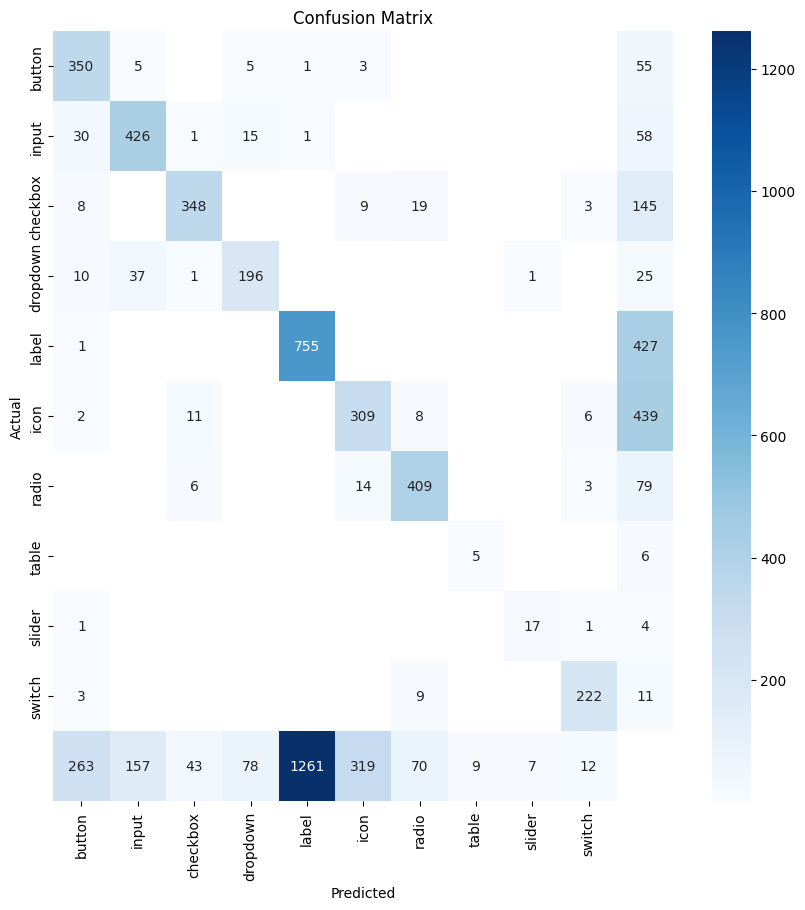

In [9]:
confusion_matrix = process_detections(test,pred,label_dict)
display(confusion_matrix,test,label_dict,output_path)
show_plot(confusion_matrix,label_list,output_path)

In [ ]:
df = pd.read_csv(os.path.join(output_path,'confusion_matrix_0.5_0.5.csv'))
df2 = df.describe()
df2.to_csv(os.path.join(output_path,'description.csv'))
